In [4]:
from utils.dataset import Dataset
from model import Net
# from utils.utils import calculate_accuracy

from torch.utils.data import DataLoader
import torch.nn as nn
import torch
import numpy as np
import itertools

from sklearn.model_selection import train_test_split
import snntorch.functional as SF

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)
batch_size = 128

Device:  cuda


In [3]:
data_path = '/home/ubuntu/Desktop/Projects/SNN/ecg_snn/dataset/'
print("Loading dataset from: ", data_path)
dataset = Dataset()
records,annotations = dataset.load_dataset(data_path)
X = []
y = []
X, y = dataset.preprocess(records, annotations)

if X or y is not None:
    print("Signals loaded successfully..................")

Loading dataset from:  /home/ubuntu/Desktop/Projects/SNN/ecg_snn/dataset/
Loading dataset from:  /home/ubuntu/Desktop/Projects/SNN/ecg_snn/dataset/
Signals loaded successfully..................


In [4]:
import snntorch as snn
from snntorch import spikeplot as splt
import torch

In [7]:
# Network Architecture
num_inputs = 360
num_hidden = 512
num_outputs = 5
population = 100

# Temporal Dynamics
num_steps = 1
beta1 = torch.randn(178)
beta3 = torch.randn(100)
beta4 = torch.randn(5)

dtype = torch.float

In [10]:
from snntorch.spikegen import rate_conv
import snntorch as snn

# Define Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=5)
        self.lif1 = snn.Leaky(beta=beta1, learn_beta=True, learn_threshold=True)
        self.pool = nn.MaxPool1d(kernel_size=2)

        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=5)
        self.conv_out_size = self.calculate_conv_output_size()
        self.lif2 = snn.Leaky(beta=torch.randn(self.conv_out_size), learn_beta=True, learn_threshold=True)

        self.fc1 = nn.Linear(64 * self.conv_out_size, 100)
        self.lif3 = snn.Leaky(beta=beta3, learn_beta=True, learn_threshold=True)

        self.fc2 = nn.Linear(100, 5)
        self.lif4 = snn.Leaky(beta=beta4, learn_beta=True, learn_threshold=True)

    def calculate_conv_output_size(self):
        # Calculate the output size after convolutions and pooling
        x = torch.randn(1, 1, 360)  # Example input
        x = self.pool(self.conv1(x))
        x = self.pool(self.conv2(x))
        return x.size(2)
    
    def forward(self, x):
        # x = rate_conv(x)
        x = x.unsqueeze(1)
        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()
        mem4 = self.lif4.init_leaky()

        # Record the final layer
        spk4_rec = []
        mem4_rec = []


        cur1 = self.conv1(x)
        spk1, mem1 = self.lif1(self.pool(cur1), mem1)
        cur2 = self.conv2(spk1)
        spk2, mem2 = self.lif2(self.pool(cur2), mem2)
        cur3 = self.fc1(spk2.flatten(1))
        spk3, mem3 = self.lif3(cur3, mem3)
        cur4 = self.fc2(spk3)
        spk4, mem4 = self.lif4(cur4, mem4)

        spk4_rec.append(spk4)
        mem4_rec.append(mem4)

        return torch.stack(spk4_rec, dim=0), torch.stack(mem4_rec, dim=0) # time-steps x batch x num_out

# Load the network onto CUDA if available
net = Net().to(device)

In [10]:
from sklearn.model_selection import train_test_split

import numpy as np

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=104, train_size=0.8, shuffle=True)
X_train = torch.tensor(X_train , dtype=torch.float32)
X_test = torch.tensor(X_test , dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)


training_set = torch.utils.data.TensorDataset(X_train, y_train)
test_set = torch.utils.data.TensorDataset(X_test, y_test)

train_loader = DataLoader(training_set, batch_size=128, shuffle=True)
test_loader = DataLoader(test_set, batch_size=128, shuffle=True)

/tmp/ipykernel_36269/1070483246.py:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  X_train = torch.tensor(X_train , dtype=torch.float32)


In [7]:
def print_batch_accuracy(data, targets, train=False):
    output, _ = net(data)
    _, idx = output.sum(dim=0).max(1)
    acc = np.mean((targets == idx).detach().cpu().numpy())

    if train:
        print(f"Train set accuracy for a single minibatch: {acc*100:.2f}%")
    else:
        print(f"Test set accuracy for a single minibatch: {acc*100:.2f}%")

def train_printer():
    print(f"Epoch {epoch}, Iteration {iter_counter}")
    print(f"Train Set Loss: {loss_hist[counter]:.2f}")
    print(f"Test Set Loss: {test_loss_hist[counter]:.2f}")
    print_batch_accuracy(data, targets, train=True)
    print_batch_accuracy(test_data, test_targets, train=False)
    print("\n")

In [12]:
num_epochs = 5
loss_hist = []
test_loss_hist = []
counter = 0

# loss = SF.ce_max_membrane_loss()
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))

In [13]:
for epoch in range(num_epochs):
    iter_counter = 0
    train_batch = iter(train_loader)

    # Minibatch training loop
    for data, targets in train_batch:
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        net.train()

        try:
          spk_rec, mem_rec = net(data)
        except:
          print(data.shape)
          print(data)
          print(data.view(batch_size, -1).shape)
          print("error")
          break

        # initialize the loss & sum over time
        loss_val = torch.zeros((1), dtype=dtype, device=device)
        for step in range(num_steps):
            loss_val += loss(mem_rec[step], targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Test set
        with torch.no_grad():
            net.eval()
            test_data, test_targets = next(iter(test_loader))
            test_data = test_data.to(device)
            test_targets = test_targets.to(device)

            # Test set forward pass
            test_spk, test_mem = net(test_data.view(batch_size, -1))

            # Test set loss
            test_loss = torch.zeros((1), dtype=dtype, device=device)
            for step in range(num_steps):
                test_loss += loss(test_mem[step], test_targets)
            test_loss_hist.append(test_loss.item())

            # Print train/test loss/accuracy
            if counter % 50 == 0:
                train_printer()
            counter += 1
            iter_counter +=1

Epoch 0, Iteration 0
Train Set Loss: 1.64
Test Set Loss: 1.64
Train set accuracy for a single minibatch: 75.00%
Test set accuracy for a single minibatch: 79.69%


Epoch 0, Iteration 50
Train Set Loss: 0.84
Test Set Loss: 0.76
Train set accuracy for a single minibatch: 76.56%
Test set accuracy for a single minibatch: 80.47%


Epoch 0, Iteration 100
Train Set Loss: 0.76
Test Set Loss: 0.99
Train set accuracy for a single minibatch: 81.25%
Test set accuracy for a single minibatch: 68.75%


Epoch 0, Iteration 150
Train Set Loss: 0.82
Test Set Loss: 0.75
Train set accuracy for a single minibatch: 74.22%
Test set accuracy for a single minibatch: 75.78%


Epoch 0, Iteration 200
Train Set Loss: 0.72
Test Set Loss: 0.61
Train set accuracy for a single minibatch: 79.69%
Test set accuracy for a single minibatch: 81.25%


Epoch 0, Iteration 250
Train Set Loss: 0.84
Test Set Loss: 0.72
Train set accuracy for a single minibatch: 73.44%
Test set accuracy for a single minibatch: 82.81%


Epoch 0, Iter

In [14]:
torch.save(net.state_dict(), "models/csnn.pt")

In [15]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
def all_parameters(model):
    return sum(p.numel() for p in model.parameters())

print(f"Number of trainable parameters: {count_parameters(net)}")
print(f"Total number of parameters: {all_parameters(net)}")

Number of trainable parameters: 568275
Total number of parameters: 568275


In [16]:
print("Model's state_dict:")
for param_tensor in net.state_dict():
    print(param_tensor, "\t", net.state_dict()[param_tensor].size())

Model's state_dict:
conv1.weight 	 torch.Size([32, 1, 5])
conv1.bias 	 torch.Size([32])
lif1.threshold 	 torch.Size([])
lif1.beta 	 torch.Size([178])
lif1.graded_spikes_factor 	 torch.Size([])
lif1.reset_mechanism_val 	 torch.Size([])
conv2.weight 	 torch.Size([64, 32, 5])
conv2.bias 	 torch.Size([64])
lif2.threshold 	 torch.Size([])
lif2.beta 	 torch.Size([87])
lif2.graded_spikes_factor 	 torch.Size([])
lif2.reset_mechanism_val 	 torch.Size([])
fc1.weight 	 torch.Size([100, 5568])
fc1.bias 	 torch.Size([100])
lif3.threshold 	 torch.Size([])
lif3.beta 	 torch.Size([100])
lif3.graded_spikes_factor 	 torch.Size([])
lif3.reset_mechanism_val 	 torch.Size([])
fc2.weight 	 torch.Size([5, 100])
fc2.bias 	 torch.Size([5])
lif4.threshold 	 torch.Size([])
lif4.beta 	 torch.Size([5])
lif4.graded_spikes_factor 	 torch.Size([])
lif4.reset_mechanism_val 	 torch.Size([])


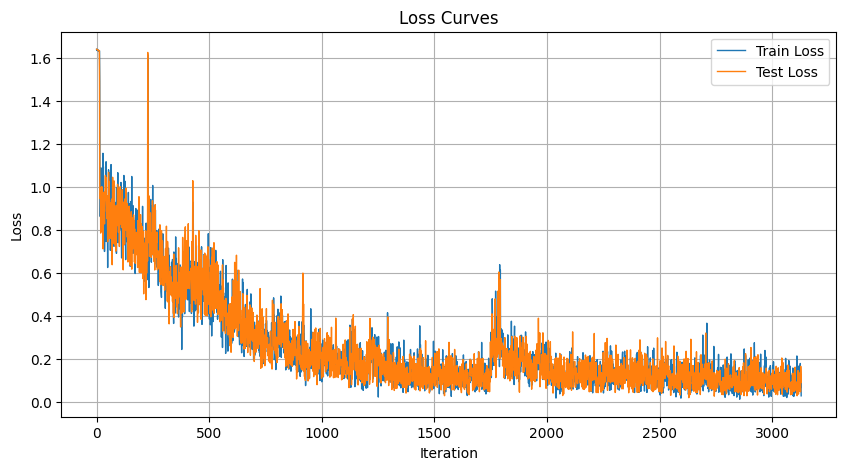

In [17]:
import matplotlib.pyplot as plt

fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist)
plt.plot(test_loss_hist)
plt.title("Loss Curves")
plt.legend(["Train Loss", "Test Loss"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

In [18]:
total = 0
correct = 0

with torch.no_grad():
  net.eval()
  for data, targets in test_loader:
    data = data.to(device)
    targets = targets.to(device)

    # forward pass
    test_spk, _ = net(data.view(data.size(0), -1))

    # calculate total accuracy
    _, predicted = test_spk.sum(dim=0).max(1)
    total += targets.size(0)
    correct += (predicted == targets).sum().item()

print(f"Total correctly classified test set images: {correct}/{total}")
print(f"Test Set Accuracy: {100 * correct / total:.2f}%")

Total correctly classified test set images: 19191/20003
Test Set Accuracy: 95.94%


In [1]:
! pip install torchsummary

In [11]:
# import torchsummary

# # You need to define input size to calcualte parameters
# torchsummary.summary(net, input_size=(128, 1, 360))

RuntimeError: Expected 2D (unbatched) or 3D (batched) input to conv1d, but got input of size: [2, 1, 128, 1, 360]